In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


In [2]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [3]:
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

## PCA with a linear autoencorder

In [5]:
import numpy as np

m = 200
w1,w2 = 0.1,0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)

In [8]:
#normalize

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

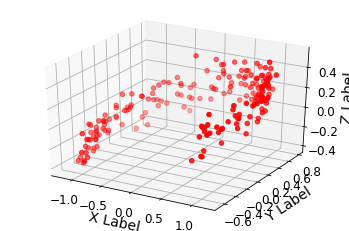

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data[:,0], data[:,1], data[:,2], c='r', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

Build the encoder to embed in 2d, which is just PCA,
If autoencoder uses only linear acitivations, its just the same as PCA

In [13]:
import tensorflow as tf

reset_graph()

n_inputs = 3
n_hidden = 2  # codings
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape = [None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

#set the loss
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [15]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X:X_train})
    codings_val = codings.eval(feed_dict={X:X_test})

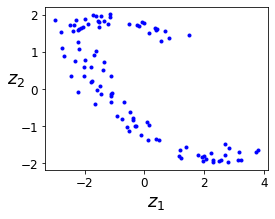

In [16]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

## Stack autoencoders

In [17]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Train all layers at once

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (ie. 2 stacked Autoencoders). We will use ELU activation, He initialization and L2 regularization.

In [18]:
reset_graph()

from functools import partial

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs  = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape = [None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
#Equivalent to:
#he_init = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))

l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() # not shown in the book

In [22]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict ={X:X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess,"./my_model_all_layers.ckpt")

0 Train MSE: 0.026385158
1 Train MSE: 0.014072447
2 Train MSE: 0.010306657
3 Train MSE: 0.010390229
4 Train MSE: 0.010949131


In [23]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


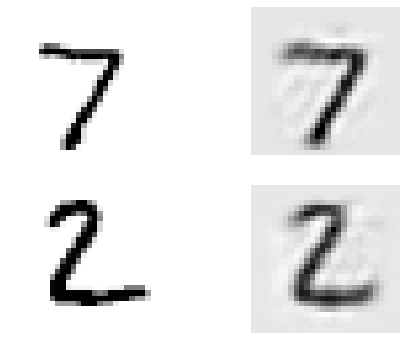

In [24]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")

## Tying Weights

take the tranpose of the layer in the encoder and use that weight matrix as the connections weights in the decoder. Specifically, if the autoencoder has a total of N layers (not counting the input layer) and $W_{L}$ represents the connection of the eights of the Lth layer, then the decoder layer can be defined as $W_{N-L+1}$ = $W_{L}^T$

In [25]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [26]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")


0 Train MSE: 0.016662525
1 Train MSE: 0.015471292
2 Train MSE: 0.016651146
3 Train MSE: 0.017186422
4 Train MSE: 0.018500516


## Training one autoencoder at a time in multiple graphs

There are many ways to train one Autoencoder at a time. The first approach is to train each Autoencoder using a different graph, then we create the Stacked Autoencoder by simply initializing it with the weights and biases copied from these Autoencoders.

Let's create a function that will train one autoencoder and return the transformed training set (i.e., the output of the hidden layer) and the model parameters.

In [29]:
reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005, seed=42,
                      hidden_activation=tf.nn.elu,
                      output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = np.random.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]
    
        
        
        

Now lets train the two Autoencoders. The first one is trained on training data, and the second is trained on the autoencoders hidden layer ouput

In [30]:
#get the hidden layer outputs and corresponding weights
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150,
                                                  output_activation=None)

0 Train MSE: 0.018916825
1 Train MSE: 0.018875364
2 Train MSE: 0.018895075
3 Train MSE: 0.019581487


In [31]:
#retrain using the other part of the autoencoder
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)



0 Train MSE: 0.004271179
1 Train MSE: 0.0046978276
2 Train MSE: 0.004606748
3 Train MSE: 0.004794933


Finally, we can create a stacked autoencoder by simply reusing the wiehgts and biases from the autoencoders we just trained on:

In [34]:
reset_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

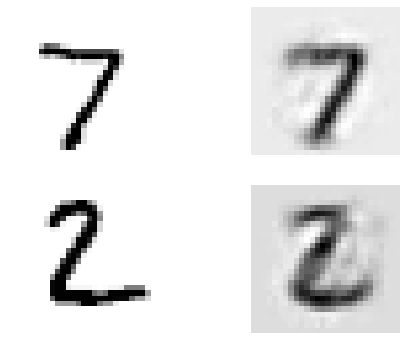

In [35]:
show_reconstructed_digits(X, outputs)


## Training one autoencoder at atime in a single graph

Rather than training the whole stacked autoencoder in one go, it is often much faster to train one shallowe auto enocder at a time, then stack all of htem in a singel stacked

During the first phas of trainng, the first autoenocder learns to roncstruct the inputs. In, the second phase, the second autoencoder learns to reconstruct the output of the first autoencoder's hidden lary.

In [37]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # bypass hidden2 and hidden3
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) 
    #not freeze hidden1

In [38]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [44]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4,4]
batch_sizes = [150,150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_one_at_a_time.ckpt")
    loss_test1 = reconstruction_loss[0].eval(feed_dict={X: mnist.test.images})
    loss_test2 = reconstruction_loss[1].eval(feed_dict={X: mnist.test.images})
    print("Test MSE phase 1:", loss_test1)
    print('Test MSE phase 2:', loss_test2)

Training phase #1
0 Train MSE: 0.008078277
1 Train MSE: 0.0072973133
2 Train MSE: 0.0075434702
3 Train MSE: 0.007695529
Training phase #2
0 Train MSE: 0.2327423
1 Train MSE: 0.009098654
2 Train MSE: 0.003249949
3 Train MSE: 0.002198817
Test MSE phase 1: 0.0077808015
Test MSE phase 2: 0.0022398627


In [43]:
reconstruction_loss

[<tf.Tensor 'phase1/Mean:0' shape=() dtype=float32>,
 <tf.Tensor 'phase2/Mean:0' shape=() dtype=float32>]

## Cache frozen layer outputs

In [46]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = np.random.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_cache_frozen.ckpt")
    loss_test1 = reconstruction_loss[0].eval(feed_dict={X: mnist.test.images})
    loss_test2 = reconstruction_loss[1].eval(feed_dict={X: mnist.test.images})
    print("Test MSE phase 1:", loss_test1)
    print('Test MSE phase 2:', loss_test2)

Training phase #1
0 Train MSE: 0.00735475
1 Train MSE: 0.0072939442
2 Train MSE: 0.008012873
3 Train MSE: 0.007925841
Training phase #2
0 Train MSE: 0.12319803
1 Train MSE: 0.005043149
2 Train MSE: 0.0025040866
3 Train MSE: 0.0019973523
Test MSE phase 1: 0.007963993
Test MSE phase 2: 0.0020648295


## Visiualize the reconstructions


INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


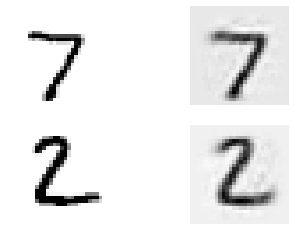

In [47]:
n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt") # not shown in the book
    outputs_val = outputs.eval(feed_dict={X: X_test})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

### Now lets see what the autoencoder learned 

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


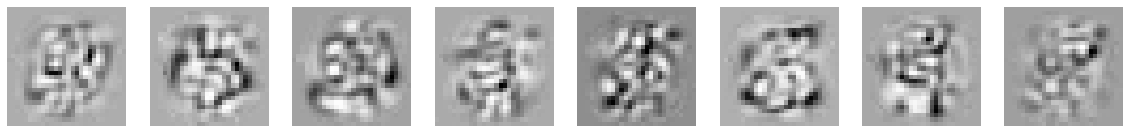

In [53]:
model = "./my_model_one_at_a_time.ckpt"

with tf.Session() as sess:
    saver.restore(sess, model)
    weights1_val = weights1.eval()
n=8
plt.figure(figsize=(20,20))
for i in range(n):
    plt.subplot(1,n,i+1)
    plot_image(weights1_val.T[i])
plt.show()

## Unupervised pre-training

In the case you have some labeld training but not all

POssible to train a high performance model using only little training data because your neural network won't have to learn all the low-level featrues, it will just reuse feature detecitrs learned by the existing net

Similiarly, if you have a large dataset, you can first train a stacked autoencdoer  using all the data, then reuse the lower layers to create a neural network for your actual task and then train it using the labeled data

In [54]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = activation(tf.matmul(X,weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

In [57]:
n_epochs = 10
batch_size = 150
n_labeled_instances = 21000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = np.random.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

0 Train accuracy: 0.9533333 Test accuracy: 0.9393
1 Train accuracy: 0.9866667 Test accuracy: 0.9425
2 Train accuracy: 0.98 Test accuracy: 0.9439
3 Train accuracy: 0.9533333 Test accuracy: 0.9448
4 Train accuracy: 0.97333336 Test accuracy: 0.9467
5 Train accuracy: 0.96666664 Test accuracy: 0.9132
6 Train accuracy: 1.0 Test accuracy: 0.9512
7 Train accuracy: 0.98 Test accuracy: 0.9497
8 Train accuracy: 0.98 Test accuracy: 0.9571
9 Train accuracy: 0.99333334 Test accuracy: 0.9452


Now reusing the first two layers of the autoencoder

In [66]:
n_epochs = 10
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess,'./my_model_cache_frozen.ckpt')
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100*iteration // n_batches),end="")
            sys.stdout.flush()
            indices = np.random.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X:X_batch,y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_batch,y:y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        saver.save(sess, "./my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt
0 Train accuracy: 0.96666664	Test accuracy: 0.8976
1 Train accuracy: 0.9266667	Test accuracy: 0.9284
2 Train accuracy: 0.94666666	Test accuracy: 0.9472
3 Train accuracy: 0.98	Test accuracy: 0.9518
4 Train accuracy: 0.97333336	Test accuracy: 0.9305
5 Train accuracy: 0.99333334	Test accuracy: 0.952
6 Train accuracy: 0.96	Test accuracy: 0.9466
7 Train accuracy: 0.9866667	Test accuracy: 0.954
8 Train accuracy: 0.98	Test accuracy: 0.9422
9 Train accuracy: 0.98	Test accuracy: 0.949


## Stacked denoising autoencoder

Another way to force the autoencoder to learn useful features is to add noice to its inputs, training it to recover the original noise free inputs. 

In [67]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [68]:
noise_level = 0.8

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level*tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs") # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [69]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [70]:
n_epochs = 15
batch_size = 230

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian.ckpt")

0 Train MSE: 0.045451406
1 Train MSE: 0.04304303
29% Train MSE: 0.040419422
3 Train MSE: 0.038165767
4 Train MSE: 0.04045741
5 Train MSE: 0.037434015
6 Train MSE: 0.038571782
7 Train MSE: 0.037789628
8 Train MSE: 0.03828574
9 Train MSE: 0.038667366
10 Train MSE: 0.036699302
11 Train MSE: 0.03785473
12 Train MSE: 0.0368084
13 Train MSE: 0.036230303
14 Train MSE: 0.036316


Apply using dropout

In [71]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [72]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.dropout instead.


In [73]:
n_epochs = 12
batch_size = 350

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_dropout.ckpt")

0 Train MSE: 0.034538373
1 Train MSE: 0.029623635
2 Train MSE: 0.028041843
3 Train MSE: 0.02624672
4 Train MSE: 0.0256019
5 Train MSE: 0.025865195
6 Train MSE: 0.025427507
7 Train MSE: 0.024298038
8 Train MSE: 0.026143987
9 Train MSE: 0.024729786
10 Train MSE: 0.024856338
11 Train MSE: 0.025411133


INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_dropout.ckpt


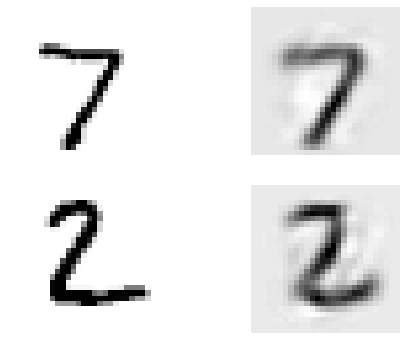

In [74]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising_dropout.ckpt")

## Sparse Autoencoder

Another kind of constraint that often leads to good feature extraction is sparsity, by adding an appropropriate term to the cost function, the autoencode is pushed to reduce the number of active neurons in the coding layer.

For example, it may be pushed to have an average on only 5% significantly active neurons in the coding layer. This foces the autoencoder to represent each input as a combination  of a small number of activations. As a result, each neuron in the coding layer typically ends up representing a useful feature (if you would speak only a few words per month, you would probbaly try to make them worh listening to).

In order to favor sparse models we must first measure the actual sparsity of the coding layer at each training iteration. We do so by computing the average activation of each neuron in the coding layer, over the whole training batch. The batch size must not be too small or else, the mean will not be accurate.

Once we have the mean avtivation per neuron, we want to penalize the neurons that are too active by adding a sparsity loss to the cost function. For example, if we measure that a neuron has an average activation of 0.3, but the target sparsity is 0.1 it must be penalized to activate less. One approach could be simply adding the squared error (0.3-0.1)^2

Recall the KL Divergence

$
\begin{align}
D_{KL} (P || Q) = \sum_{i} P(i) log \frac{P(i)}{Q(i)} \\
\end{align}
$

In our case, we want to measur the divergence between the target probability p that a neuron in the coding layer will activate, and the actual probability q (i.e the mean activation over the training batch can be:

$
\begin{align}
D_{KL} (p ||q) = p log\frac{p}{q} + (1-p)log\frac{1-p}{1-q} \\
\end{align}
$

[0, 1, 0, 0.95]

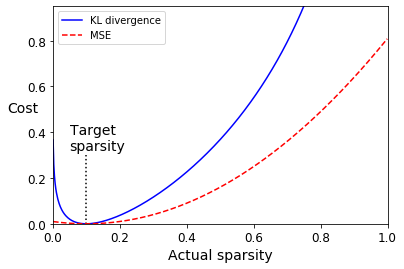

In [75]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

In [76]:
reset_graph()

n_inputs = 28*28
n_hidden1 = 1000
n_outputs = n_inputs

In [77]:
def kl_divergence(p,q):
    return(p*tf.log(p/q) + (1-p)*tf.log((1-p)/(1-q)))

In [78]:
learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32,shape=[None, n_inputs])

hidden1 = tf.layers.dense(X,n_hidden1,activation=tf.nn.sigmoid)
outputs = tf.layers.dense(hidden1,n_outputs)

hidden1_mean = tf.reduce_mean(hidden1,axis=0)
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target,hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [79]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [80]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 Train MSE: 0.1271435 	Sparsity loss: 0.58575237 	Total loss: 0.24429399
1 Train MSE: 0.059922744 	Sparsity loss: 0.013020015 	Total loss: 0.06252675
2 Train MSE: 0.05287474 	Sparsity loss: 0.12184343 	Total loss: 0.077243425
3 Train MSE: 0.04653427 	Sparsity loss: 0.30109835 	Total loss: 0.106753945
4 Train MSE: 0.044616364 	Sparsity loss: 0.019565452 	Total loss: 0.048529454
5 Train MSE: 0.041869808 	Sparsity loss: 0.04519668 	Total loss: 0.050909143
6 Train MSE: 0.038831733 	Sparsity loss: 0.039271686 	Total loss: 0.046686072
7 Train MSE: 0.035365097 	Sparsity loss: 0.026613863 	Total loss: 0.04068787
8 Train MSE: 0.033500545 	Sparsity loss: 0.022379013 	Total loss: 0.037976347
9 Train MSE: 0.029437445 	Sparsity loss: 0.045312706 	Total loss: 0.03849999
10 Train MSE: 0.026761804 	Sparsity loss: 0.33868694 	Total loss: 0.0944992
11 Train MSE: 0.02491595 	Sparsity loss: 0.44080764 	Total loss: 0.11307748
12 Train MSE: 0.023085214 	Sparsity loss: 0.12103707 	Total loss: 0.047292627
13

INFO:tensorflow:Restoring parameters from ./my_model_sparse.ckpt


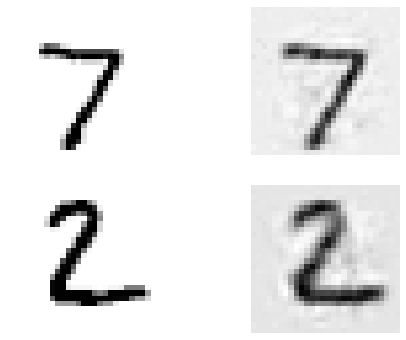

In [81]:
show_reconstructed_digits(X, outputs, "./my_model_sparse.ckpt")

To speed up training, normalize the outputs between 0 and 1 and use cross entrop instead of the MSE

In [82]:
hidden1 = tf.layers.dense(X,n_hidden1, activation=tf.nn.sigmoid)

logits = tf.layers.dense(hidden1, n_outputs)
outputs = tf.nn.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_mean(xentropy)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Variational autoencoders

The are probablistics autoencoders, meaning that their outputs are partly determined by change, even after trainig (as opposed to denoiseing autoencoders which uses randomnes only during training)

Most importantly they are generative autoencoders, meaning that they can generate new instance that look like the ere sampled from the training set

Both these properties make them rather similar to RMBS but are easier to train and the sampling process is much faster

Pretty much the same thing as regular autoencoders, instead of directly producing a coding for a given input, the encoder produces a mean coding $\mu$ and standard deviation $\sigma$.

THe cost function is made up of two parts. The first us the usual reconstruction loss that pushes the autoenccoder to reproduce it inputs (we can use cross entropy for this, as discussed earlier).

The second is the latent loss, that pushes the autoencoder to have codingts that look as though they were sampled from a simple guassian, for which we use the KL divergence between targe and actual.

In [83]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

In [85]:
#define the loss function
eps = 1e-10
latent_loss = 0.5*tf.reduce_sum(
            tf.square(hidden3_sigma) + tf.square(hidden3_mean) - 
                1 - tf.log(eps + tf.square(hidden3_sigma)))

In [86]:
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [87]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

0 Train total loss: 31386.232 	Reconstruction loss: 24002.814 	Latent loss: 7383.4175
1 Train total loss: 27185.764 	Reconstruction loss: 22075.969 	Latent loss: 5109.7944
2 Train total loss: 24243.773 	Reconstruction loss: 20322.525 	Latent loss: 3921.2483
3 Train total loss: 27870.953 	Reconstruction loss: 21980.422 	Latent loss: 5890.5312
4 Train total loss: 33582.855 	Reconstruction loss: 23690.754 	Latent loss: 9892.101
5 Train total loss: 24403.975 	Reconstruction loss: 21250.496 	Latent loss: 3153.4783
6 Train total loss: 23228.57 	Reconstruction loss: 20110.703 	Latent loss: 3117.8682
7 Train total loss: 18876.883 	Reconstruction loss: 16146.83 	Latent loss: 2730.052
8 Train total loss: 17773.305 	Reconstruction loss: 14658.631 	Latent loss: 3114.6729
9 Train total loss: 17324.562 	Reconstruction loss: 14217.837 	Latent loss: 3106.7253
10 Train total loss: 16689.305 	Reconstruction loss: 13511.956 	Latent loss: 3177.3481
11 Train total loss: 16064.714 	Reconstruction loss: 1293

## Generate Digits

In [90]:
import numpy as np

n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt")  # not shown
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 32914.008 	Reconstruction loss: 24969.602 	Latent loss: 7944.408
1 Train total loss: 30359.96 	Reconstruction loss: 23160.406 	Latent loss: 7199.554
2 Train total loss: 29577.938 	Reconstruction loss: 22822.84 	Latent loss: 6755.0977
3 Train total loss: 28764.77 	Reconstruction loss: 22496.469 	Latent loss: 6268.3
4 Train total loss: 24702.371 	Reconstruction loss: 21322.613 	Latent loss: 3379.7576
5 Train total loss: 19846.896 	Reconstruction loss: 16720.467 	Latent loss: 3126.429
6 Train total loss: 18266.336 	Reconstruction loss: 15410.434 	Latent loss: 2855.9019
7 Train total loss: 17998.59 	Reconstruction loss: 14998.965 	Latent loss: 2999.6257
8 Train total loss: 17511.81 	Reconstruction loss: 14393.162 	Latent loss: 3118.649
9 Train total loss: 16767.355 	Reconstruction loss: 13678.466 	Latent loss: 3088.8901
10 Train total loss: 16953.514 	Reconstruction loss: 13782.087 	Latent loss: 3171.426
11 Train total loss: 17065.105 	Reconstruction loss: 14075.195 	La

In [89]:
np.random.normal(size=[10,10])

array([[-0.78396683, -1.85899511, -0.48143491,  1.0206352 ,  0.77969619,
        -0.52941186, -1.30683127,  0.09040731, -0.10106699,  0.45393774],
       [ 0.08302393, -0.76151274,  1.90287641, -0.17721598, -1.60731432,
        -1.95838956,  2.00963074, -0.79390064, -0.34875943,  0.10889491],
       [ 0.39115841, -0.32232236, -2.97406045, -2.15685951,  0.11114845,
        -0.6069575 ,  0.15111265, -0.26994246,  3.08907633,  0.50298672],
       [ 0.04774987,  1.85363499,  0.05381682,  1.45732682,  0.34308938,
        -1.24568763,  0.87616123, -1.05280038, -0.6487753 ,  1.15195679],
       [ 0.8022181 , -0.114121  , -0.17761686,  2.11182829, -0.30759063,
        -0.22321401,  0.0111348 , -0.52839191,  0.59749743, -0.14532586],
       [ 1.00354787,  1.15183327, -1.35558177,  0.41809633,  1.28158988,
        -1.79586257, -0.71695069,  0.44464936, -0.42356133, -0.36967439],
       [ 2.28620068, -1.55083253, -0.45495771,  0.3649869 , -0.09152401,
        -1.20443965, -0.64341426,  0.32661993

In [91]:
outputs_val.shape

(60, 784)

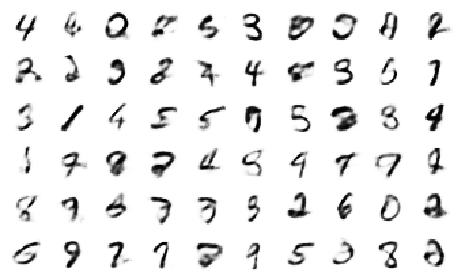

In [92]:
plt.figure(figsize=(8,50))
for iteration in range(n_digits):
    plt.subplot(n_digits,10,iteration+1)
    plot_image(outputs_val[iteration])

## Encode and Decode

In [93]:
n_digits = 10
X_test, y_test = mnist.test.next_batch(batch_size)
codings = hidden3

In [94]:
X_test.shape

(150, 784)

In [95]:
y_test.shape

(150,)

In [96]:
#Encode
with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    codings_val = codings.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


In [97]:
codings_val.shape

(150, 20)

Note we went from 784 to 20

In [98]:
#Decode
with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_val})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


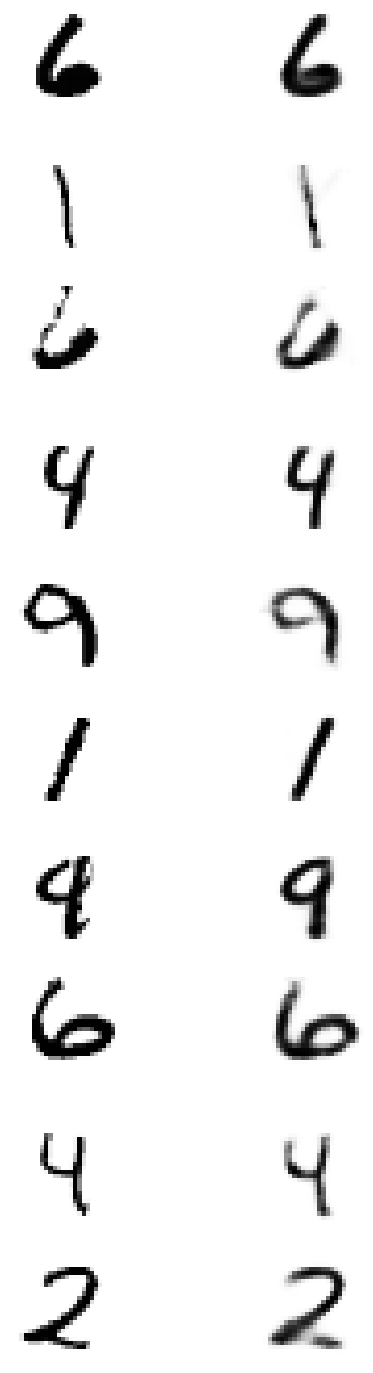

In [99]:
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])

## Interpolate digits

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


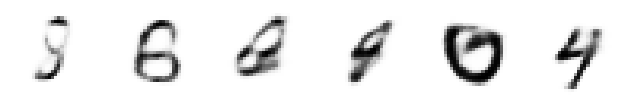

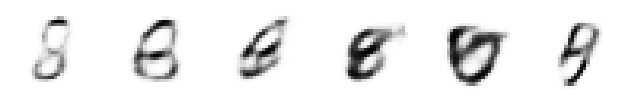

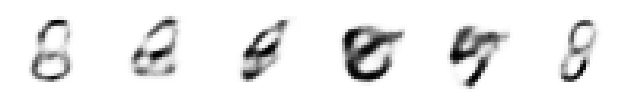

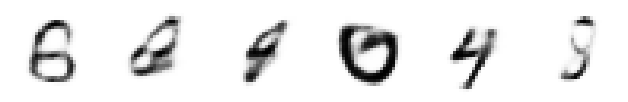

In [106]:
n_iterations = 3
n_digits = 6
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    target_codings = np.roll(codings_rnd, -1, axis=0)
    for iteration in range(n_iterations+1):
        codings_interpolate = codings_rnd + \
        (target_codings - codings_rnd)*iteration / n_iterations
        
        outputs_val = outputs.eval(feed_dict={codings:codings_interpolate})
        plt.figure(figsize=(11,1.5*n_iterations))
        for digit_index in range(n_digits):
            plt.subplot(1,n_digits,digit_index +1)
            plot_image(outputs_val[digit_index])
        plt.show()

In [101]:
codings_rnd.shape

(60, 20)

In [103]:
np.roll(codings_rnd,-1,axis=0).shape

(60, 20)